<a href="https://colab.research.google.com/github/benhachy/TATR/blob/main/Using_Table_Transformer_for_table_detection_and_table_structure_recognition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table Transformer: inference notebook

In this notebook, we are going to run the Table Transformer - which is actually a [DETR](https://arxiv.org/abs/2005.12872) model - by Microsoft Research (which is part of 🤗 Transformers) to perform table detection and table structure recognition on documents.

### Quick intro: DETR
DETR is short for DEtection TRansformer, and consists of a convolutional backbone (ResNet-50 or ResNet-101) followed by an encoder-decoder Transformer. It can be trained end-to-end to perform object detection (and panoptic segmentation, for that see my other notebooks in my repo [Transformers-tutorials](https://github.com/NielsRogge/Transformers-Tutorials)).The main contribution of DETR is its simplicity: compared to other models like Faster R-CNN and Mask R-CNN, which rely on several highly engineered things like region proposals, non-maximum suppression procedure and anchor generation, DETR is a model that can simply be trained end-to-end, and fine-tuned just like you would fine-tune BERT. This is possible due to the use of a clever loss function, the so-called **bipartite matching loss**. I highly recommend [Yannic Kilcher's video](https://www.youtube.com/watch?v=T35ba_VXkMY&t=1693s) if you want to understand how the full model works.

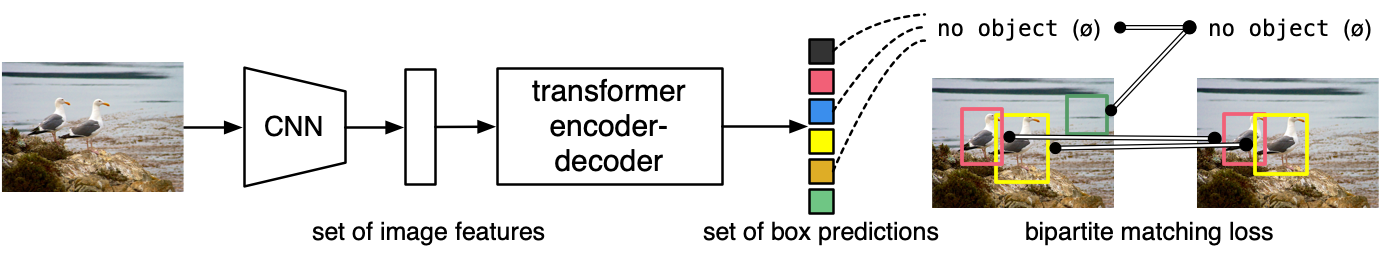

* Table Transformer paper: https://arxiv.org/abs/2110.00061
* DETR Paper: https://arxiv.org/abs/2005.12872
* DETR Blog post: https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/
* Official Github repository: https://github.com/facebookresearch/detr

My other DETR notebooks (which showcase how you can fine-tune DETR on a custom dataset, both for object detection and panoptic segmentation) can be found [here](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/DETR).


In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.6 MB/s eta 0:00:00


In [2]:
!pip install -q timm
!pip install -q ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00


In [3]:
import os
import ipdb

### Loading PubTables-1M (Table Structure Recognition Subset)

In [28]:
!wget 'https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Images_Test.tar.gz'

--2023-09-25 15:24:59--  https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Images_Test.tar.gz
Resolving huggingface.co (huggingface.co)... 18.172.134.124, 18.172.134.88, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/36/c0/36c021133128a16f57db86f4cb105c85b76fb8fb4968b96642a02b5140872630/6f711dc11d7198169f35184a103b1f34efab5cb41c4acc90501845a01e23f568?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27PubTables-1M-Structure_Images_Test.tar.gz%3B+filename%3D%22PubTables-1M-Structure_Images_Test.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1695914699&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5NTkxNDY5OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8zNi9jMC8zNmMwMjExMzMxMjhhMTZmNTdkYjg2ZjRjYjEwNWM4NWI3NmZi

In [29]:
import tarfile

# Images directory
images_path = '/content/images'

# Creating the directory where we extract the image files
if not os.path.exists(images_path):
  os.mkdir(images_path)

# Specify the path to your tar.gz file
file_path = 'PubTables-1M-Structure_Images_Test.tar.gz'  # Replace with the actual path to your file

# Extract the files from the tar.gz file
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path = '/content/images/')

# How many images do we have?
import os
images_names = os.listdir('/content/images')

# # Checking that every file is an image

num_not_img = len(list(filter(lambda d: not(d.endswith('.jpg')) , images_names)))

# Print the number of tables images we have
print(f" Number of files:{len(images_names)} \n Non-image file count:  {num_not_img}")

 Number of files:93834 
 Non-image file count:  0


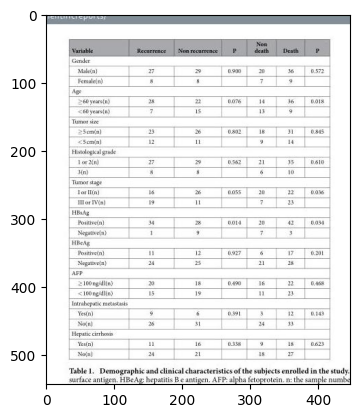

In [30]:
import matplotlib.pyplot as plt

# Read the first image
image = plt.imread('/content/images/' + images_names[1])
plt.imshow(image)

### Exploring the DetrFeatureExtractor:

In [ ]:
import numpy as np

def min_max_normalize(arr):
    min_value = arr.min()
    max_value = arr.max()
    normalized_data = (arr - min_value) / (max_value - min_value)
    return normalized_data

In [ ]:
image1 = plt.imread('/content/images/' + images_names[1])
image2 = plt.imread('/content/images/' + images_names[2])

In [ ]:
pixel_val = np.array(feature_extractor([image1, image2])['pixel_values'])

pixel_val.shape

NameError: ignored

In [ ]:
img_features = feature_extractor(image)['pixel_values'][0].reshape((467,1334,3))
img_features = min_max_normalize(img_features)

plt.figure(figsize=(20,15))
plt.imshow(img_features)

## Creating a DataSet:

In [31]:
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, images_names, feature_extractor, transform=None):
        self.images_names = images_names
        self.feature_extractor = feature_extractor # Preparing the image for the extraction using DetrFeatureExtractor
        self.transform = transform

    def __len__(self):
        #return len(self.images_names)
        return np.array(self.images_names).shape[0]

    def __getitem__(self, idx):
        image_name = self.images_names[idx]
        image_path = os.path.join('/content/images', image_name)
        image = Image.open(image_path)
        image_width = image.size[0]
        image_height = image.size[1]

        #ipdb.set_trace()
        if self.transform:
            image = self.transform(image)
        encoding = self.feature_extractor(images=image, return_tensors="pt")

        return {"pixel_values":encoding.pixel_values, "pixel_mask":encoding.pixel_mask, 'image_name': image_name, 'image_width': image_width, 'image_height': image_height} #16, 224, 224, 3

In [32]:
BATCH_SIZE = 48
SEED_VALUE = 42

In [33]:
torch.manual_seed(SEED_VALUE)
import numpy as np
np.random.seed(SEED_VALUE)

transform = transforms.Compose([
    transforms.Resize((800, 800)),  # Resize the image to the desired dimensions
    transforms.ToTensor(),           # Convert to tensor
])


from transformers import DetrFeatureExtractor
feature_extractor = DetrFeatureExtractor()

tables_dataloader = DataLoader(
    CustomDataset(images_names, feature_extractor, transform),
    batch_size=BATCH_SIZE,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


In [34]:
sample_table_batch = tables_dataloader.__iter__().__next__()
sample_table_batch.keys() # pixel_values, pixel_mask

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


dict_keys(['pixel_values', 'pixel_mask', 'image_name', 'image_width', 'image_height'])

In [35]:
(sample_table_batch['pixel_values']).shape

torch.Size([48, 1, 3, 800, 800])

## 1- DETECTING ROWS AND COLUMNS (Table Structure Recognition)

In [6]:
from transformers import TableTransformerForObjectDetection

table_recognition_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### niels example

In [ ]:
image = image.resize((800,800))
image.size

(800, 800)

In [ ]:
temp_features = feature_extractor(image)
temp_outputs = table_recognition_model(pixel_values = torch.tensor(temp_features['pixel_values']), pixel_mask = torch.tensor(temp_features['pixel_mask']) )
temp_outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

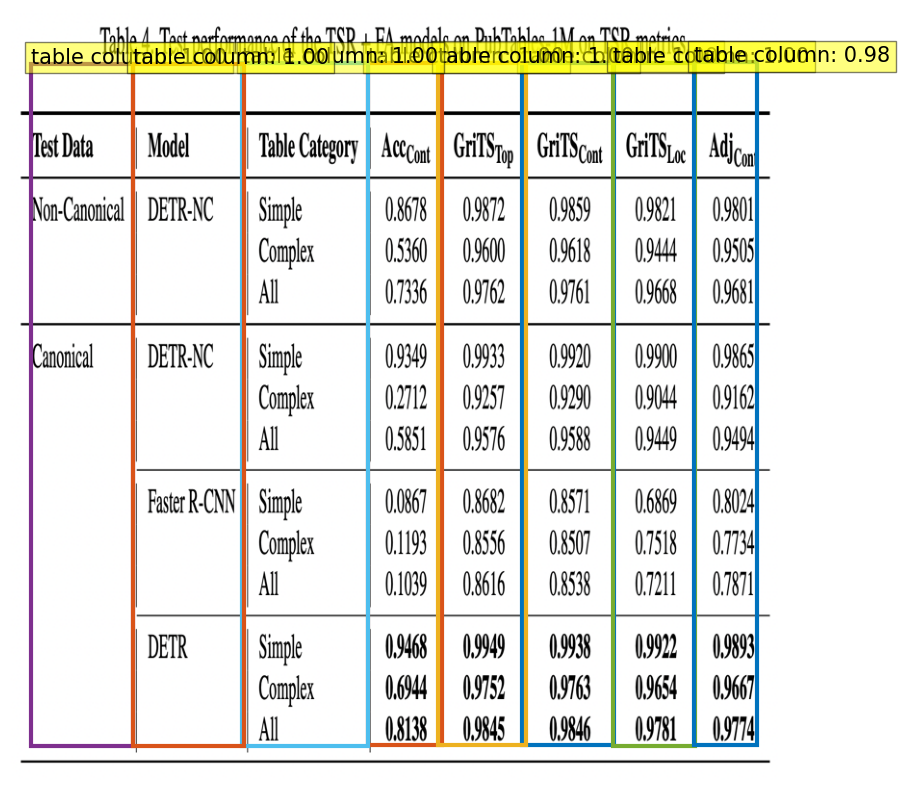

In [ ]:

temp_results = feature_extractor.post_process_object_detection(temp_outputs, threshold=0.6, target_sizes=[(800,800)])[0] #pil_img.size gives (width, height ) while target_sizes expect height, width

label_mask = temp_results['labels'] == 1

custom_temp_results = {'scores': temp_results['scores'][label_mask], 'labels': temp_results['labels'][label_mask], 'boxes': (temp_results['boxes'])[label_mask] }

plot_results(image, **custom_temp_results)


### Our dataset:

In [7]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes, label=None):

    # To plot only the boxes corresponding to a specific label
    if label:
      label_mask = labels== label

      # Selecting the corresponding boxes and respective scores
      boxes = boxes[label_mask]
      scores = scores[label_mask]

    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100

    for score, label, (xmin, ymin, xmax, ymax), c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{table_recognition_model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

#### Testing on a sample batch:

In [ ]:
# Taking only one image
sample_pixel_values = sample_table_batch['pixel_values'].squeeze()
sample_pixel_mask = sample_table_batch['pixel_mask'].squeeze()
sample_image_name = sample_table_batch['image_name']
sample_image_width = sample_table_batch['image_width']
sample_image_height = sample_table_batch['image_height']

# Moving to GPU
table_recognition_model = table_recognition_model.cuda()
sample_pixel_values = sample_pixel_values.cuda()
sample_pixel_mask = sample_pixel_mask.cuda()

# Calculating
with torch.no_grad():
  outputs = table_recognition_model(pixel_values=sample_pixel_values, pixel_mask=sample_pixel_mask)

outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

In [ ]:
from easydict import EasyDict
img_idx = np.random.randint(16)

# Opening a random image from the sample batch data
pil_img = Image.open('/content/images/' + sample_image_name[img_idx])

# Getting its corresponding outputs
sample_outputs= {key: value[img_idx].unsqueeze(0) for key,value in outputs.items()}

# Post processing the results
results = feature_extractor.post_process_object_detection(EasyDict(sample_outputs), threshold=0.6, target_sizes= [pil_img.size[::-1]])[0] #pil_img.size gives (width, height ) while target_sizes expect height, width
results

{'scores': tensor([0.6757, 0.7332, 0.8745, 0.8392, 0.6089, 0.9297, 0.7708, 0.8453, 0.6156,
         0.7740, 0.7354, 0.7099, 0.6215, 0.6328, 0.6082, 0.7977, 0.6018, 0.8461,
         0.8370, 0.9095], device='cuda:0'),
 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 0],
        device='cuda:0'),
 'boxes': tensor([[ 47.6463, 358.1888, 475.1504, 400.8292],
         [ 47.7692, 438.6771, 474.4753, 480.6078],
         [ 48.8269, 136.6458, 473.2437, 176.6965],
         [ 46.2269, 198.0960, 475.1477, 237.5399],
         [ 49.5198, 101.8816, 476.9167, 142.6346],
         [ 48.7888, 104.6737, 473.2442, 142.9815],
         [ 48.6193,  75.6721, 474.7672, 107.7498],
         [ 48.1574, 170.0159, 474.0902, 210.1186],
         [ 43.9017,  46.9558, 122.0008, 509.0851],
         [ 48.3274, 316.5217, 473.5614, 358.1518],
         [ 48.7167, 383.1850, 472.3294, 425.7355],
         [ 45.2555,  42.9031, 475.4996,  70.8115],
         [349.3105,  52.0960, 439.2043, 506.1766],
      

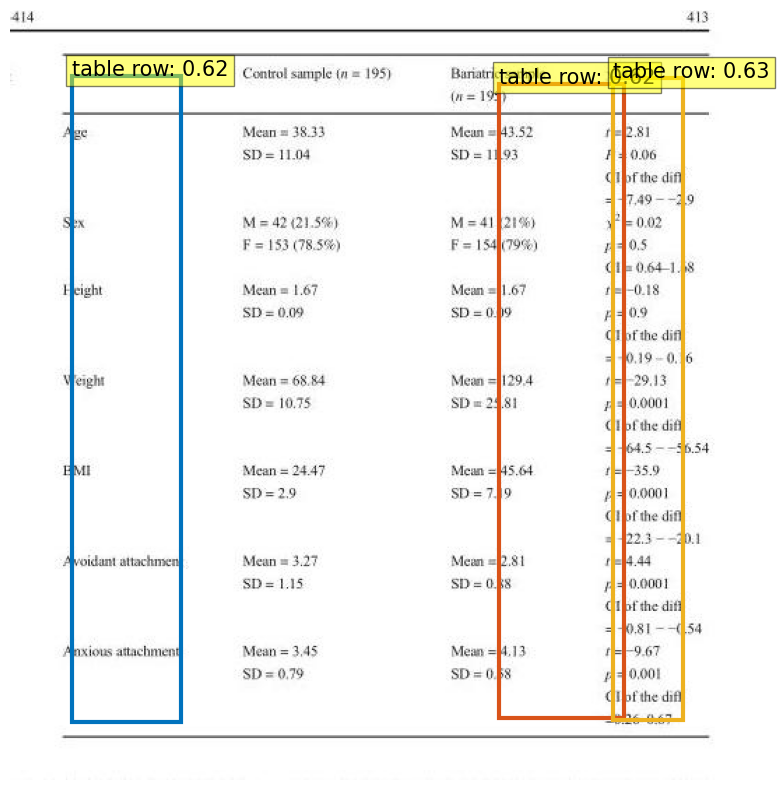

In [ ]:
plot_results(pil_img, results['scores'], results['labels'], results['boxes'], label = 1)

#### Inference on our dataset:

In [ ]:
from easydict import EasyDict
from tqdm import tqdm
import pandas as pd

# Init
if torch.cuda.is_available():
  table_recognition_model = table_recognition_model.cuda()

final_df = pd.DataFrame()
# Iterating over batches
for batch_idx, table_batch in tqdm(enumerate(tables_dataloader)):
  pixel_values = table_batch['pixel_values'].squeeze()
  pixel_mask = table_batch['pixel_mask'].squeeze()
  image_name = table_batch['image_name']
  image_height = table_batch['image_height']
  image_width = table_batch['image_width']

  # Moving to GPU
  pixel_values = pixel_values.cuda()
  pixel_mask = pixel_mask.cuda()

  # Desactivate the grad for inference
  with torch.no_grad():
    outputs = table_recognition_model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # Freeing up GPU memory
    del pixel_values
    del pixel_mask

  # Post processing batch outputs
  batch_results = feature_extractor.post_process_object_detection(EasyDict(outputs), threshold=0.6, target_sizes=list(zip(image_height, image_width)))

  # Converting to a temp df and concatenating to the final df
  batch_df = pd.DataFrame(batch_results)
  batch_df['image_name'] = image_name

  final_df = pd.concat([final_df, batch_df])


  # Stop at batch 15
  if batch_idx == 15:
    break


final_df = final_df[['image_name' , 'boxes', 'labels', 'scores']]
final_df

15it [01:55,  7.68s/it]


,scores,labels,boxes,image_name
0,"[tensor(0.6412, device='cuda:0'), tensor(0.716...","[tensor(2, device='cuda:0'), tensor(2, device=...","[[tensor(46.2274, device='cuda:0'), tensor(281...",PMC6022878_table_0.jpg
1,"[tensor(0.6417, device='cuda:0'), tensor(0.728...","[tensor(2, device='cuda:0'), tensor(2, device=...","[[tensor(32.9191, device='cuda:0'), tensor(128...",PMC4724402_table_0.jpg
2,"[tensor(0.6542, device='cuda:0'), tensor(0.728...","[tensor(2, device='cuda:0'), tensor(2, device=...","[[tensor(56.6372, device='cuda:0'), tensor(100...",PMC2956544_table_0.jpg
3,"[tensor(0.6557, device='cuda:0'), tensor(0.733...","[tensor(2, device='cuda:0'), tensor(2, device=...","[[tensor(31.5997, device='cuda:0'), tensor(334...",PMC2435238_table_1.jpg
4,"[tensor(0.6667, device='cuda:0'), tensor(0.741...","[tensor(2, device='cuda:0'), tensor(2, device=...","[[tensor(32.6547, device='cuda:0'), tensor(213...",PMC4650288_table_4.jpg
...,...,...,...,...
43,"[tensor(0.6613, device='cuda:0'), tensor(0.726...","[tensor(2, device='cuda:0'), tensor(2, device=...","[[tensor(53.4552, device='cuda:0'), tensor(262...",PMC6109043_table_3.jpg
44,"[tensor(0.6511, device='cuda:0'), tensor(0.730...","[tensor(2, device='cuda:0'), tensor(2, device=...","[[tensor(32.5671, device='cuda:0'), tensor(130...",PMC3101655_table_0.jpg
45,"[tensor(0.6436, device='cuda:0'), tensor(0.722...","[tensor(2, device='cuda:0'), tensor(2, device=...","[[tensor(45.1371, device='cuda:0'), tensor(90....",PMC3129319_table_2.jpg
46,"[tensor(0.6588, device='cuda:0'), tensor(0.730...","[tensor(2, device='cuda:0'), tensor(2, device=...","[[tensor(37.5617, device='cuda:0'), tensor(184...",PMC5948936_table_0.jpg


In [ ]:
final_df.to_pickle('final_df.pkl')

## 2- EXTRACTING TEXT USING AN OCR

In [8]:
!pip install -q pytesseract

In [9]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (10.1 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120895 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [17]:
import pandas as pd
final_df = pd.read_pickle('/content/boxes_df.pkl')

# Preprocessing final_df
final_df.scores = final_df.scores.apply(lambda score:[float(x) for x in score])
final_df.labels = final_df.labels.apply(lambda label:[int(lab) for lab in label])
final_df.boxes = final_df.boxes.apply(lambda regions:[[float(x) for x in region] for region in regions])

final_df.sample(3)

,image_name,boxes,labels,scores
39,PMC5129928_table_0.jpg,"[[59.21065139770508, 271.82769775390625, 601.1...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, ...","[0.6226401329040527, 0.7268351912498474, 0.855..."
9,PMC1716159_table_3.jpg,"[[60.71070861816406, 205.42799377441406, 604.5...","[2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, ...","[0.6556376814842224, 0.7214024066925049, 0.865..."
17,PMC4657244_table_0.jpg,"[[60.28422927856445, 170.52243041992188, 602.0...","[2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, ...","[0.6718840599060059, 0.7348237037658691, 0.873..."


#### Applying the OCR to the rows:

In [18]:
exploded_df = final_df.explode(['boxes', 'labels', 'scores']).copy()

exploded_df

,image_name,boxes,labels,scores
0,PMC6022878_table_0.jpg,"[46.22736358642578, 281.54718017578125, 464.19...",2,0.641249
0,PMC6022878_table_0.jpg,"[46.7727165222168, 333.66534423828125, 462.939...",2,0.716317
0,PMC6022878_table_0.jpg,"[47.546173095703125, 105.44235229492188, 462.0...",2,0.862334
0,PMC6022878_table_0.jpg,"[44.831321716308594, 152.5241241455078, 464.04...",2,0.823361
0,PMC6022878_table_0.jpg,"[48.310691833496094, 78.6529769897461, 465.692...",2,0.631527
...,...,...,...,...
47,PMC6178261_table_2.jpg,"[58.63838195800781, 256.0367736816406, 604.170...",2,0.606394
47,PMC6178261_table_2.jpg,"[59.29499435424805, 120.42227935791016, 604.13...",2,0.794743
47,PMC6178261_table_2.jpg,"[61.87272644042969, 190.17742919921875, 601.01...",2,0.83916
47,PMC6178261_table_2.jpg,"[60.99540710449219, 175.2826385498047, 600.982...",2,0.832895


In [19]:
import pytesseract

def extract_text(img_name, box):
  pil_img = Image.open('/content/images/' + img_name)
  cropped_img = pil_img.crop(box)
  box_text = pytesseract.image_to_string(cropped_img)
  #display(cropped_img)
  return box_text

In [ ]:
tqdm.pandas()

subset_df = exploded_df.sample(n=300, random_state=SEED_VALUE)

subset_df['box_text'] = subset_df.progress_apply(lambda row: extract_text(row['image_name'], row['boxes']), axis=1)

subset_df

100%|██████████| 300/300 [02:23<00:00,  2.09it/s]


,image_name,boxes,labels,scores,box_text
18,PMC4517449_table_0.jpg,"[35.193321228027344, 101.70040130615234, 343.0...",2,0.778835,aa eee nn\n(eo1s0)\n\nKV8073. 89998 are Moris ...
11,PMC3528759_table_0.jpg,"[61.81103515625, 36.75700759887695, 597.375671...",2,0.629128,
21,PMC3011642_table_1.jpg,"[41.552005767822266, 30.385055541992188, 406.5...",2,0.770390,
29,PMC6082097_table_0.jpg,"[45.72600173950195, 11.955004692077637, 126.98...",1,0.611781,State\n\nssochusetts 2\nFlorida\n\nAlabama 5)\...
2,PMC2836275_table_0.jpg,"[48.3032341003418, 53.86725997924805, 500.9685...",2,0.832808,16 Surface probe\n\n \n
...,...,...,...,...,...
39,PMC5828443_table_0.jpg,"[63.21411895751953, 218.6002197265625, 621.580...",2,0.821659,"“and\n\n4384163,\n\n0.83.\n\n0.34\n\n0372\n\n1..."
24,PMC4827023_table_0.jpg,"[39.20112609863281, 102.5407943725586, 389.820...",2,0.837838,SROSA26-5gRNAI-Dn | nance gogatctegicatcgrctec...
24,PMC5731501_table_3.jpg,"[33.0032958984375, 115.2917709350586, 328.5537...",2,0.663010,
6,PMC5815542_table_1.jpg,"[57.02154541015625, 40.00349426269531, 550.983...",2,0.927198,Cost (BRL) QALYs: LYG\n


#### Applying the OCR to the cells:

In [20]:
table_recognition_model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [50]:
def find_intersection(box1, box2):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Calculate the intersection coordinates
    x1_intersection = max(x1_1, x1_2)
    y1_intersection = max(y1_1, y1_2)
    x2_intersection = min(x2_1, x2_2)
    y2_intersection = min(y2_1, y2_2)

    # Check if there is an intersection
    if x1_intersection < x2_intersection and y1_intersection < y2_intersection:
        return (x1_intersection, y1_intersection, x2_intersection, y2_intersection)
    else:
        return None  # No intersection

def generate_cells(boxes, labels):
  if (1 not in labels) or (2 not in labels):
    return None
  else:
    row_mask = np.array(labels) == 1
    col_mask = np.array(labels) == 2

    row_boxes = np.array(boxes)[row_mask]
    col_boxes = np.array(boxes)[col_mask]

    cell_boxes = []
    for row_box in row_boxes:
      for col_box in col_boxes:
        cell_box = find_intersection(row_box, col_box)
        if cell_box:
          cell_boxes.append(cell_box)
  return cell_boxes

def generate_cells_and_scores(boxes, scores, labels):
  if (1 not in labels) or (2 not in labels):
    return None
  else:
    row_mask = np.array(labels) == 1
    col_mask = np.array(labels) == 2

    # Getting row boxes and col boxes
    row_boxes = np.array(boxes)[row_mask]
    col_boxes = np.array(boxes)[col_mask]

    # Getting row scores and col scores
    row_scores = np.array(scores)[row_mask]
    col_scores = np.array(scores)[col_mask]

    # Init stuff
    cell_boxes = []
    cell_scores = []

    for row_box, row_score in zip(row_boxes, row_scores):
      for col_box, col_score in zip(col_boxes, col_scores):
        cell_box = find_intersection(row_box, col_box)

        # In case of an intersection
        if cell_box:
          cell_boxes.append(cell_box)

          cell_score = row_score * col_score
          cell_scores.append(cell_score)

  return cell_boxes, cell_scores

In [54]:
# Generating cells for the final_df
from tqdm import tqdm; tqdm.pandas(); import numpy as np

final_df[['cell_boxes', 'cell_scores']] = final_df.progress_apply(lambda row: generate_cells_and_scores(boxes = row['boxes'], scores = row['scores'], labels = row['labels']), axis = 1, result_type='expand')

# Saving
#final_df.to_pickle('cells_df.pkl')
final_df.sample()

100%|██████████| 768/768 [00:00<00:00, 2152.88it/s]


,image_name,boxes,labels,scores,cell_boxes,cell_scores
44,PMC5845262_table_5.jpg,"[[60.723384857177734, 536.3539428710938, 604.9...","[2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, ...","[0.6772832274436951, 0.7269154191017151, 0.873...","[(60.723384857177734, 536.3539428710938, 154.7...","[0.41479153836507976, 0.4451879992489012, 0.53..."


In [53]:
final_df.progress_apply(lambda row: generate_cells_and_scores(boxes = row['boxes'], scores = row['scores'], labels = row['labels']), axis = 1)

100%|██████████| 768/768 [00:00<00:00, 2305.49it/s]


0     ([(46.22736358642578, 281.54718017578125, 119....
1     ([(32.919105529785156, 128.81491088867188, 84....
2     ([(56.63715362548828, 100.03557586669922, 145....
3     ([(31.599714279174805, 334.81805419921875, 81....
4     ([(32.65473175048828, 213.7651824951172, 84.03...
                            ...                        
43    ([(53.455223083496094, 262.71234130859375, 137...
44    ([(32.56705856323242, 130.9083251953125, 84.44...
45    ([(45.1370964050293, 90.87004089355469, 116.56...
46    ([(37.56166076660156, 184.1744842529297, 97.01...
47    ([(60.62849807739258, 195.1766357421875, 155.7...
Length: 768, dtype: object

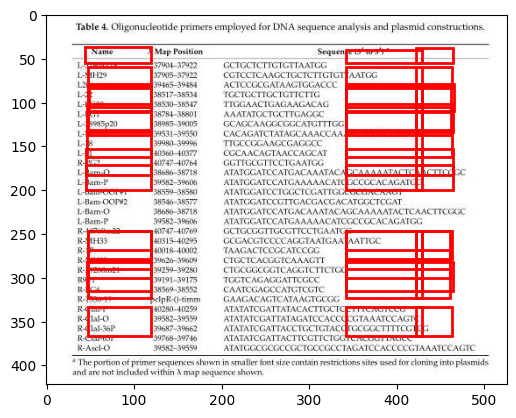

In [36]:
# Trying on an example
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_boxes_on_image(image_path, boxes):
    # Load the image
    image = Image.open(image_path)

    # Create a Matplotlib figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Loop through the list of boxes and draw each one
    for box in boxes:
        x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the image with the boxes
    plt.show()

# Trying out the function
image_name = final_df.image_name.iloc[0]
pil_img = Image.open('/content/images/' + image_name)

test_boxes = final_df.boxes.iloc[0]
test_labels = final_df.labels.iloc[0]

cell_boxes = generate_cells(boxes = test_boxes, labels = test_labels)

# Example usage:
plot_boxes_on_image('/content/images/' + image_name, cell_boxes)


NEXT STEP: Generate a score for each cell (score_cell = score_row * score_col)

## Table detection

Table detection is the task of - you guessed it - detect tables in document images, like PDFs.

Let's load a PDF and see how our model does.

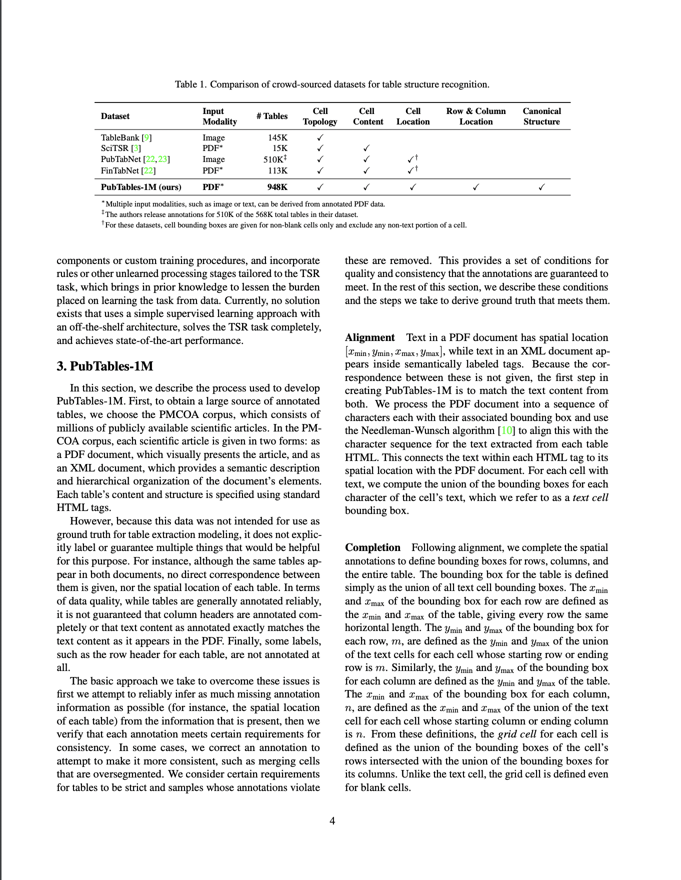

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_pdf.png")
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's first apply the regular image preprocessing using `DetrFeatureExtractor`. The feature extractor will resize the image (minimum size = 800, max size = 1333), and normalize it across the channels using the ImageNet mean and standard deviation.

In [ ]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1033, 800])


### Forward pass

Next, let's send the pixel values and pixel mask through the model. We first load the model from the hub, and perform a forward pass.

In [ ]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

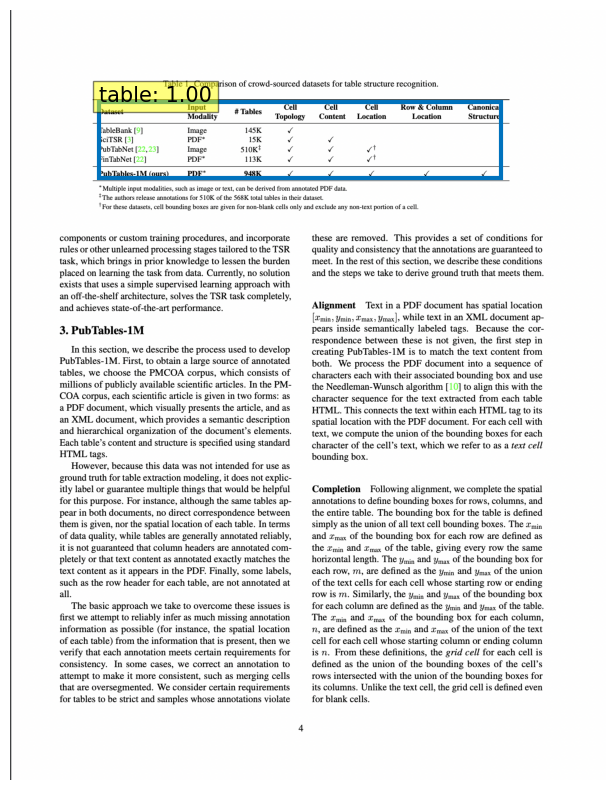

In [ ]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

Cool! Seems like our model has correctly identified the single table present in the PDF.

## Table structure recognition

Table structure recognition is the task of identifying the several rows, columns, cells in a table.

Let's load a demo table (which I took from the [paper](https://openaccess.thecvf.com/content/CVPR2022/html/Smock_PubTables-1M_Towards_Comprehensive_Table_Extraction_From_Unstructured_Documents_CVPR_2022_paper.html)) and see how our model does.

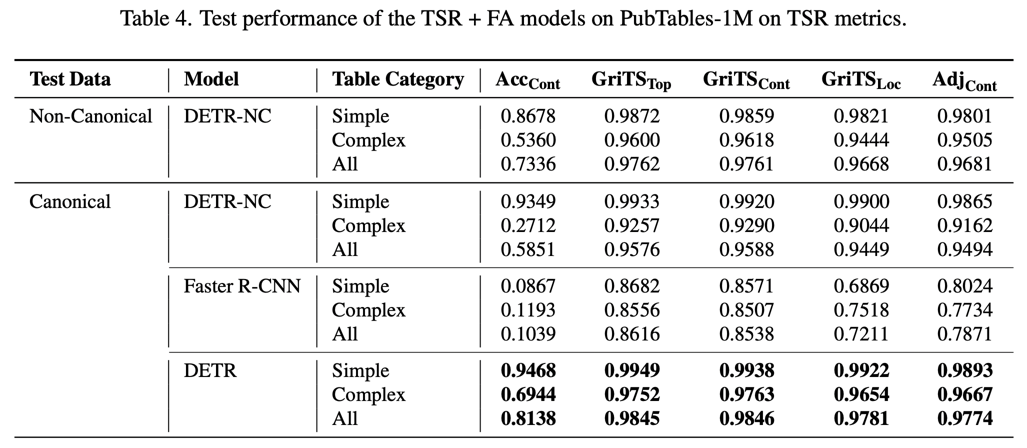

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's prepare the image for the model using `DetrFeatureExtractor`.

In [ ]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

Let's load the model from the hub, and perform a forward pass.

In [ ]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

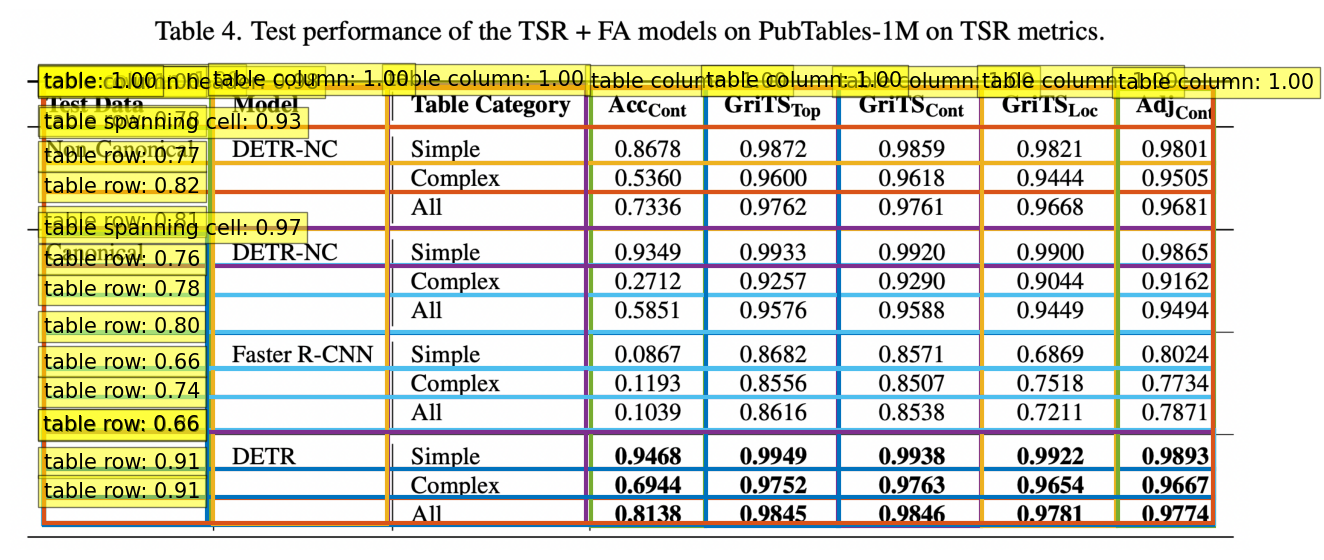

In [ ]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [ ]:
results

{'scores': tensor([0.7818, 0.9094, 0.8190, 0.9996, 0.9995, 0.7614, 0.9992, 0.7655, 0.7816,
         0.8138, 0.9999, 0.7961, 0.8562, 0.9973, 0.9996, 0.9995, 0.9995, 0.6596,
         0.9082, 0.9802, 0.9996, 0.7440, 0.9283, 0.6625, 0.9690, 1.0000]),
 'labels': tensor([2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 3, 1, 2, 5, 2,
         5, 0]),
 'boxes': tensor([[  55.1625,  473.8491, 1992.9238,  536.2683],
         [  55.4169,  760.5422, 1993.0583,  808.9153],
         [  55.5170,  302.8054, 1993.0104,  364.1293],
         [1370.9203,  128.7774, 1607.9895,  856.0112],
         [ 961.6448,  128.3521, 1151.3483,  855.8168],
         [  55.3619,  423.8597, 1993.0262,  472.4117],
         [1153.1301,  127.8595, 1372.5353,  855.7993],
         [  55.5993,  253.6965, 1993.0969,  302.4271],
         [  55.4433,  194.0559, 1993.0710,  253.7692],
         [  55.7711,  361.3059, 1992.7142,  424.7832],
         [  55.7679,  126.7103,  331.8651,  853.5883],
         [  55.1420,  534.7481,

In [ ]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [ ]:
label_mask = results['labels'] == 5

label_mask

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False,  True, False])

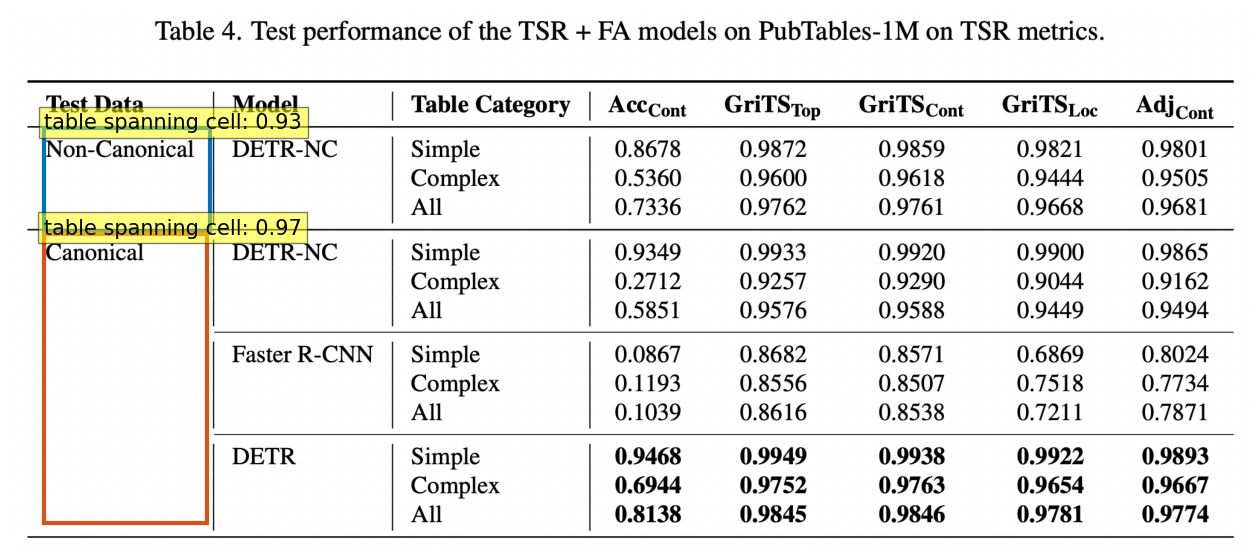

In [ ]:
custom_results = {'scores': results['scores'][label_mask], 'labels': results['labels'][label_mask], 'boxes': results['boxes'][label_mask] }

plot_results(image, **custom_results)